# An optimization problem with non-bound constraints

In [3]:
# Import the necessary modules
from pySOT import *
from poap.controller import ThreadController, BasicWorkerThread
import numpy as np

# Decide how many evaluations we are allowed to use
maxeval = 500

# (1) Optimization problem
# Use the 10-dimensional Keane bump function
data = Keane(dim=10)
print(data.info)

# (2) Experimental design
# Use a symmetric Latin hypercube with 2d + 1 samples
exp_des = SymmetricLatinHypercube(dim=data.dim, npts=2*data.dim+1)

# (3) Surrogate model
# Use a cubic RBF interpolant with a linear tail
surrogate = RBFInterpolant(kernel=CubicKernel, tail=LinearTail, maxp=maxeval)

# (4) Adaptive sampling
# Use DYCORS with 100d candidate points
adapt_samp = CandidateDYCORS(data=data, numcand=100*data.dim)

10-dimensional Keane bump function 
Global optimum: -0.835 for large n


# Use the strategy that supports non-bound constraints through a penalty method

In [4]:
# Use the threaded controller
controller = ThreadController()

# (5) Use the sychronous strategy WITH constraints
# Use 4 threads and allow for 4 simultaneous evaluations
nthreads = 4
strategy = SyncStrategyPenalty(
        worker_id=0, data=data, maxeval=maxeval, nsamples=nthreads,
        exp_design=exp_des, response_surface=surrogate, 
        sampling_method=adapt_samp)
controller.strategy = strategy

# Launch the threads and give them access to the objective function
for _ in range(nthreads):
    worker = BasicWorkerThread(controller, data.objfunction)
    controller.launch_worker(worker)

# Returns f(x) is feasible, infinity otherwise
def feasible_merit(record):
    return record.value if record.feasible else np.inf
    
# Run the optimization strategy and ask the controller for the best FEASIBLE solution
result = controller.run(merit=feasible_merit)
best, xbest = result.value, result.params[0]

# Print the final result
print('Best value found: {0}'.format(result.value))
print('Best solution found: {0}'.format(
    np.array_str(result.params[0], max_line_width=np.inf,
                precision=5, suppress_small=True)))

# Check constraints
print('\nConstraint 1: 0.75 - prod(x) = {0}'.format(0.75 - np.prod(xbest)))
print('Constraint 2: sum(x) - 7.5*dim = {0}'.format(np.sum(xbest) - 7.5*data.dim))

Best value found: -0.65305055412
Best solution found: [ 3.11243  3.17252  3.00098  0.72594  0.58935  0.35934  0.4844   0.48774  0.43981  1.7137 ]

Constraint 1: 0.75 - prod(x) = -0.0612214080541
Constraint 2: sum(x) - 7.5*dim = -60.9137897226


## Make a progress plot

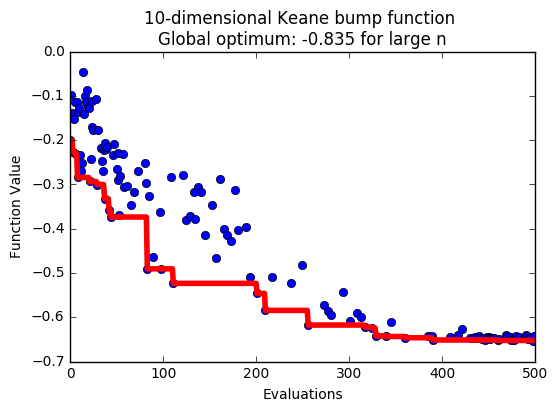

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

# Extract function values from the controller
fvals = np.array([feasible_merit(o) for o in controller.fevals])

f, ax = plt.subplots()
ax.plot(np.arange(0,maxeval), fvals, 'bo')  # Points
ax.plot(np.arange(0,maxeval), np.minimum.accumulate(fvals), 'r-', linewidth=4.0)  # Best value found
plt.xlabel('Evaluations')
plt.ylabel('Function Value')
plt.title(data.info)
plt.show()

## Written by, David Eriksson, dme65@cornell.edu
